# Physical Constraints

In [1]:
"""
Cell 1 — Setup, reference physics, and dataset

We use 1D linear advection on a periodic ring:
    u_t + c u_x = 0

Reference solver: conservative upwind finite-volume step:
    u^{n+1}_i = u^n_i - (c dt/dx) (u^n_i - u^n_{i-1})

This discretization conserves discrete mass:
    M^n = dx * sum_i u^n_i
"""

import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----------------------------
# Grid and time step (CFL-safe)
# ----------------------------
N  = 64
L  = 1.0
dx = L / N
c  = 1.0
dt = 0.5 * dx  # CFL = c*dt/dx = 0.5

x = np.linspace(0, L, N, endpoint=False)
CFL = c * dt / dx

def step_upwind(u_np: np.ndarray) -> np.ndarray:
    """One conservative upwind step, periodic."""
    return u_np - CFL * (u_np - np.roll(u_np, 1))

def mass(u_np: np.ndarray) -> float:
    """Discrete mass = integral approx."""
    return float(dx * u_np.sum())

# ----------------------------
# Initial conditions (multiple bumps)
# ----------------------------
def gaussian_bump(x0: float, sigma: float) -> np.ndarray:
    return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

def make_initial_conditions(n_ic: int = 128, seed: int = 0):
    rng = np.random.default_rng(seed)
    u0_list = []
    for _ in range(n_ic):
        x0 = float(rng.uniform(0.0, 1.0))
        sigma = float(rng.uniform(0.04, 0.10))
        amp = float(rng.uniform(0.5, 1.5))
        u0 = amp * gaussian_bump(x0, sigma)
        u0_list.append(u0.astype(np.float32))
    return np.stack(u0_list, axis=0)  # [n_ic, N]

def rollout_truth(u0_np: np.ndarray, n_steps: int = 80) -> np.ndarray:
    """Return truth trajectory [n_steps+1, N]."""
    traj = [u0_np.copy()]
    u = u0_np.copy()
    for _ in range(n_steps):
        u = step_upwind(u)
        traj.append(u.copy())
    return np.stack(traj, axis=0)

# ----------------------------
# Dataset: learn one-step mapping u^n -> u^{n+1}
# ----------------------------
n_ic = 256
n_steps_per_ic = 20  # keep small, fast

U0 = make_initial_conditions(n_ic=n_ic, seed=42)

pairs_u  = []
pairs_un = []
for k in range(n_ic):
    u = U0[k].copy()
    for _ in range(n_steps_per_ic):
        u_next = step_upwind(u)
        pairs_u.append(u.copy())
        pairs_un.append(u_next.copy())
        u = u_next

pairs_u  = np.stack(pairs_u, axis=0)   # [M, N]
pairs_un = np.stack(pairs_un, axis=0)  # [M, N]

# Torch tensors
X = torch.tensor(pairs_u,  dtype=torch.float32)
Y = torch.tensor(pairs_un, dtype=torch.float32)

print("Dataset:", X.shape, "->", Y.shape)
print("CFL:", CFL)


/media/nas/uwork1/rpotthas/ropy/lib64/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Dataset: torch.Size([5120, 64]) -> torch.Size([5120, 64])
CFL: 0.5


Truth mass: M(0)=0.225786, M(end)=0.225786, diff=+0.000e+00


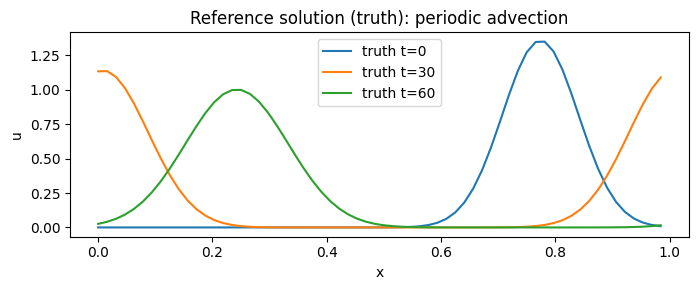

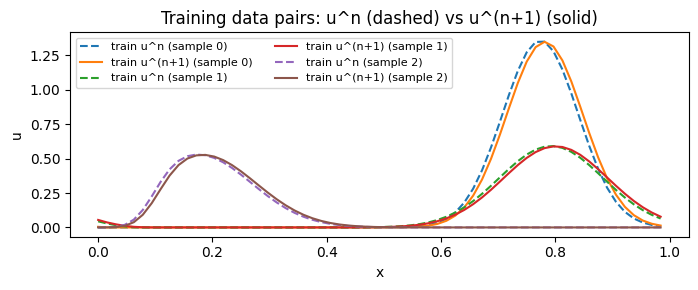

In [2]:
"""
Cell 2 — Monitoring the reference solution and the training data

(a) Plot a truth rollout at steps t=0, 30, 60 to verify physics.
(b) Plot a few training pairs (u^n and u^{n+1}) used for learning.
Also check mass conservation in truth.
"""

# Pick one initial condition for diagnostics
u0 = U0[0]
truth = rollout_truth(u0, n_steps=80)

# Truth mass check
m0 = mass(truth[0])
m_end = mass(truth[-1])
print(f"Truth mass: M(0)={m0:.6f}, M(end)={m_end:.6f}, diff={m_end-m0:+.3e}")

# Plot truth snapshots
steps_to_show = [0, 30, 60]
plt.figure(figsize=(7,3))
for s in steps_to_show:
    plt.plot(x, truth[s], label=f"truth t={s}")
plt.title("Reference solution (truth): periodic advection")
plt.xlabel("x"); plt.ylabel("u")
plt.legend()
plt.tight_layout()
plt.savefig("Advection_Periodic_Truth.png")
plt.show()

# Plot a few training pairs
idx = [0, len(X)//3, 2*len(X)//3]
plt.figure(figsize=(7,3))
for j, i in enumerate(idx):
    plt.plot(x, X[i].numpy(), linestyle="--", label=f"train u^n (sample {j})")
    plt.plot(x, Y[i].numpy(), linestyle="-",  label=f"train u^(n+1) (sample {j})")
plt.title("Training data pairs: u^n (dashed) vs u^(n+1) (solid)")
plt.xlabel("x"); plt.ylabel("u")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.savefig("Advection_Periodic_Truth_df.png")
plt.show()


In [3]:
"""
Cell 3 — Models

We use a residual step model:
    u^{n+1} = u^n + Δuθ(u^n)

Unconstrained model:
    Δuθ is arbitrary → mass can drift.

Conservative model (exact discrete mass conservation by construction):
    Δuθ <- Δuθ - mean(Δuθ)  (zero-mean update)
Then sum(u^{n+1}) = sum(u^n) exactly (up to float error).
"""

class ResidualStepNN(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(N, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, N),
        )

    def forward(self, u):
        du = self.net(u)
        return u + du  # residual update

class ConservativeResidualStepNN(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(N, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, N),
        )

    def forward(self, u):
        du = self.net(u)
        du = du - du.mean(dim=-1, keepdim=True)  # enforce sum(du)=0 per sample
        return u + du

device = "cpu"
model_free = ResidualStepNN(N).to(device)
model_cons = ConservativeResidualStepNN(N).to(device)


In [4]:
"""
Cell 4 — Training with detailed monitoring

We train:
- model_free: unconstrained residual NN
- model_cons: conservative-by-construction residual NN

Monitoring:
- print every 'print_every' epochs:
    epoch, loss_free, loss_cons, elapsed mm:ss
- store loss histories for later plotting (separate plot cell)
"""

def fmt_mmss(seconds: float) -> str:
    m = int(seconds // 60)
    s = int(seconds % 60)
    return f"{m:02d}:{s:02d}"

# Training setup
lr = 1e-3
epochs = 400
batch_size = 128
print_every = 40

opt_free = torch.optim.Adam(model_free.parameters(), lr=lr)
opt_cons = torch.optim.Adam(model_cons.parameters(), lr=lr)

loss_fn = nn.MSELoss()

# Simple mini-batching without DataLoader (fast, minimal dependencies)
num = X.shape[0]
perm = torch.randperm(num)

loss_hist_free = []
loss_hist_cons = []

t0 = time.time()
for ep in range(1, epochs + 1):
    # reshuffle each epoch for robustness
    perm = torch.randperm(num)

    total_free = 0.0
    total_cons = 0.0
    nb = 0

    for i0 in range(0, num, batch_size):
        idx = perm[i0:i0+batch_size]
        xb = X[idx].to(device)
        yb = Y[idx].to(device)

        # --- free model ---
        pred_f = model_free(xb)
        loss_f = loss_fn(pred_f, yb)
        opt_free.zero_grad()
        loss_f.backward()
        opt_free.step()

        # --- conservative model ---
        pred_c = model_cons(xb)
        loss_c = loss_fn(pred_c, yb)
        opt_cons.zero_grad()
        loss_c.backward()
        opt_cons.step()

        total_free += float(loss_f.item())
        total_cons += float(loss_c.item())
        nb += 1

    mean_free = total_free / nb
    mean_cons = total_cons / nb
    loss_hist_free.append(mean_free)
    loss_hist_cons.append(mean_cons)

    if ep % print_every == 0 or ep == 1:
        elapsed = time.time() - t0
        print(f"ep {ep:4d}/{epochs} | loss_free={mean_free:.3e} | loss_cons={mean_cons:.3e} | elapsed {fmt_mmss(elapsed)}")

print("Training done.")


ep    1/400 | loss_free=9.290e-04 | loss_cons=9.519e-04 | elapsed 00:00
ep   40/400 | loss_free=1.649e-06 | loss_cons=1.364e-06 | elapsed 00:03
ep   80/400 | loss_free=6.123e-07 | loss_cons=6.065e-07 | elapsed 00:06
ep  120/400 | loss_free=1.320e-06 | loss_cons=8.475e-07 | elapsed 00:09
ep  160/400 | loss_free=2.504e-07 | loss_cons=2.490e-07 | elapsed 00:13
ep  200/400 | loss_free=3.768e-07 | loss_cons=3.663e-07 | elapsed 00:16
ep  240/400 | loss_free=3.810e-07 | loss_cons=3.768e-07 | elapsed 00:19
ep  280/400 | loss_free=5.377e-07 | loss_cons=5.033e-07 | elapsed 00:22
ep  320/400 | loss_free=2.008e-07 | loss_cons=1.931e-07 | elapsed 00:25
ep  360/400 | loss_free=1.503e-07 | loss_cons=1.682e-07 | elapsed 00:28
ep  400/400 | loss_free=3.586e-07 | loss_cons=3.398e-07 | elapsed 00:32
Training done.


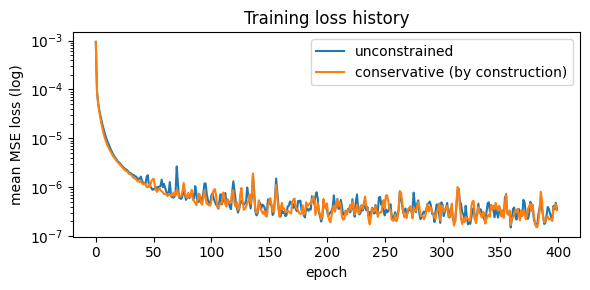

In [5]:
"""
Plot Cell A — Loss curves

Purpose:
- Verify both models actually learn the one-step mapping.
- Check whether conservative constraint hurts/help training stability.
"""

plt.figure(figsize=(6,3))
plt.plot(loss_hist_free, label="unconstrained")
plt.plot(loss_hist_cons, label="conservative (by construction)")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("mean MSE loss (log)")
plt.title("Training loss history")
plt.legend()
plt.tight_layout()
plt.savefig("Advection_Periodic_Loss_MLP.png")
plt.show()

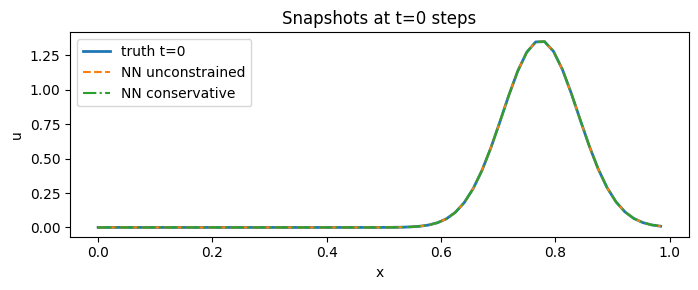

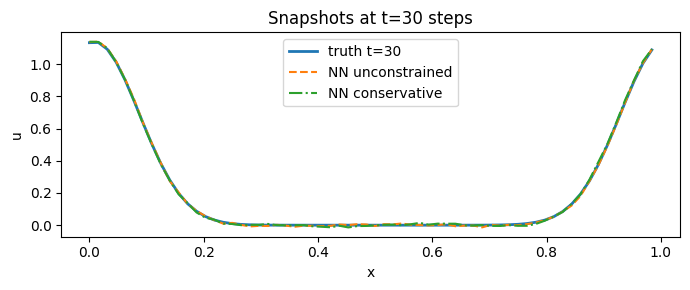

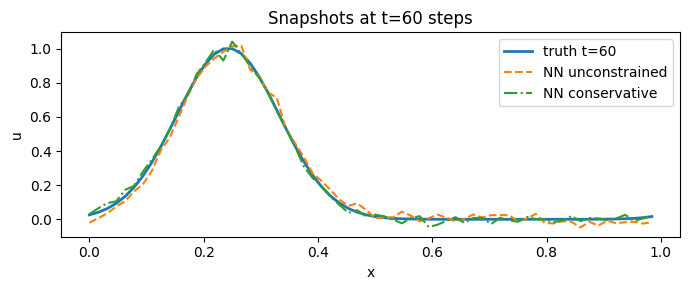

In [6]:
"""
Plot Cell B — Rollout snapshots at selected times

Purpose:
- Compare truth and NN rollouts at t=0,30,60.
- Catch nonsense immediately (shape errors, damping, drift).
"""

def rollout_model(model, u0_np, n_steps=80):
    u = torch.tensor(u0_np, dtype=torch.float32).to(device)
    traj = [u.detach().cpu().numpy().copy()]
    for _ in range(n_steps):
        u = model(u)
        traj.append(u.detach().cpu().numpy().copy())
    return np.stack(traj, axis=0)

traj_free = rollout_model(model_free, u0, n_steps=80)
traj_cons = rollout_model(model_cons, u0, n_steps=80)

steps_to_show = [0, 30, 60]
for s in steps_to_show:
    plt.figure(figsize=(7,3))
    plt.plot(x, truth[s],     label=f"truth t={s}", linewidth=2)
    plt.plot(x, traj_free[s], label="NN unconstrained", linestyle="--")
    plt.plot(x, traj_cons[s], label="NN conservative", linestyle="-.")
    plt.title(f"Snapshots at t={s} steps")
    plt.xlabel("x"); plt.ylabel("u")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Advection_Periodic_MLP_{s}.png")
    plt.show()

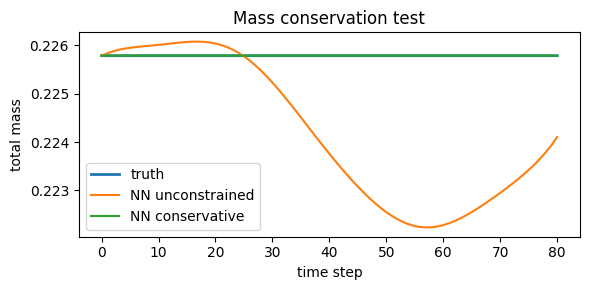

Mass drift (end-start):
 truth: +0.000e+00
 free : -1.681e-03
 cons : -2.980e-08


In [7]:
"""
Plot Cell C — Mass conservation during rollout

Purpose:
- Quantify invariant preservation.
Expected:
- truth: constant mass (up to numerical rounding)
- unconstrained NN: typically drifts
- conservative NN: should be flat (by construction)
"""

def mass_series(traj):
    return dx * traj.sum(axis=1)

m_truth = mass_series(truth)
m_free  = mass_series(traj_free)
m_cons  = mass_series(traj_cons)

plt.figure(figsize=(6,3))
plt.plot(m_truth, label="truth", linewidth=2)
plt.plot(m_free,  label="NN unconstrained")
plt.plot(m_cons,  label="NN conservative")
plt.xlabel("time step")
plt.ylabel("total mass")
plt.title("Mass conservation test")
plt.legend()
plt.tight_layout()
plt.savefig("Advection_Periodic_MLP_Mass_Conservation_Test.png")
plt.show()

print("Mass drift (end-start):")
print(f" truth: {m_truth[-1]-m_truth[0]:+.3e}")
print(f" free : {m_free[-1]-m_free[0]:+.3e}")
print(f" cons : {m_cons[-1]-m_cons[0]:+.3e}")



## Commentary — Why the first conservation attempt is not “better”

In the previous experiment we enforced mass conservation by a global constraint
(sum of the state remains constant).

What we observe:
- Mass conservation is improved compared to the unconstrained NN.
- However, the solution becomes visibly noisy and less smooth.

Why this happens:
- The conservation constraint restricts only the global mean.
- High-frequency oscillations with zero mean are still allowed.
- The network exploits these degrees of freedom to reduce the training loss.

Important lesson:
Better conservation of a single invariant does NOT automatically mean
a better or more physical solution.

This result is shown here on purpose.
It motivates the next step:
adding appropriate inductive bias (locality / smoothness via CNNs),
not just additional constraints.



# With CNN

In [8]:
"""
Cell A — CNN comparison: unconstrained vs conservative (training only)

We train two *identical* CNN step models:
1) CNN-free: local CNN, NO mass conservation
2) CNN-cons: same CNN, exact mass conservation enforced by construction

This isolates the effect of the conservation constraint.
"""

import time
import torch
import torch.nn as nn

# ----------------------------
# CNN base (shared architecture)
# ----------------------------
class CNNBase(nn.Module):
    def __init__(self, kernel_size=5):
        super().__init__()
        pad = kernel_size // 2
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size, padding=pad, padding_mode="circular"),
            nn.Tanh(),
            nn.Conv1d(16, 16, kernel_size, padding=pad, padding_mode="circular"),
            nn.Tanh(),
            nn.Conv1d(16, 1, kernel_size, padding=pad, padding_mode="circular"),
        )

    def forward_du(self, u):
        u1 = u.unsqueeze(1)              # [B,1,N]
        du = self.net(u1).squeeze(1)     # [B,N]
        return du

    def forward_du(self, u):
        # u: [B, N]
        u1 = u.unsqueeze(1)              # [B, 1, N]
        du = self.net(u1).squeeze(1)     # [B, N]
        return du


class CNNFree(nn.Module):
    def __init__(self, kernel_size=5):
        super().__init__()
        self.core = CNNBase(kernel_size)

    def forward(self, u):
        du = self.core.forward_du(u)
        return u + du


class CNNConservative(nn.Module):
    def __init__(self, kernel_size=5):
        super().__init__()
        self.core = CNNBase(kernel_size)

    def forward(self, u):
        du = self.core.forward_du(u)
        du = du - du.mean(dim=-1, keepdim=True)  # exact mass conservation
        return u + du


device = "cpu"
model_free = CNNFree(kernel_size=5).to(device)
model_cons = CNNConservative(kernel_size=5).to(device)

opt_free = torch.optim.Adam(model_free.parameters(), lr=1e-3)
opt_cons = torch.optim.Adam(model_cons.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ----------------------------
# Training loop
# ----------------------------
epochs = 400
batch_size = 128
print_every = 40

num = X.shape[0]
loss_hist_free = []
loss_hist_cons = []

def fmt_mmss(seconds):
    m = int(seconds // 60)
    s = int(seconds % 60)
    return f"{m:02d}:{s:02d}"

t0 = time.time()

for ep in range(1, epochs + 1):
    perm = torch.randperm(num)
    lf, lc, nb = 0.0, 0.0, 0

    for i0 in range(0, num, batch_size):
        idx = perm[i0:i0 + batch_size]
        xb = X[idx].to(device)
        yb = Y[idx].to(device)

        # unconstrained CNN
        pred_f = model_free(xb)
        loss_f = loss_fn(pred_f, yb)
        opt_free.zero_grad()
        loss_f.backward()
        opt_free.step()

        # conservative CNN
        pred_c = model_cons(xb)
        loss_c = loss_fn(pred_c, yb)
        opt_cons.zero_grad()
        loss_c.backward()
        opt_cons.step()

        lf += float(loss_f.item())
        lc += float(loss_c.item())
        nb += 1

    lf /= nb
    lc /= nb
    loss_hist_free.append(lf)
    loss_hist_cons.append(lc)

    if ep == 1 or ep % print_every == 0:
        elapsed = time.time() - t0
        print(
            f"ep {ep:4d}/{epochs} | "
            f"loss free={lf:.3e} | loss cons={lc:.3e} | "
            f"elapsed {fmt_mmss(elapsed)}"
        )

print("CNN comparison training finished.")


ep    1/400 | loss free=6.031e-04 | loss cons=1.009e-04 | elapsed 00:00
ep   40/400 | loss free=5.088e-07 | loss cons=8.867e-08 | elapsed 00:10
ep   80/400 | loss free=9.731e-07 | loss cons=9.383e-08 | elapsed 00:22
ep  120/400 | loss free=1.111e-07 | loss cons=4.527e-08 | elapsed 00:32
ep  160/400 | loss free=3.091e-07 | loss cons=7.891e-09 | elapsed 00:42
ep  200/400 | loss free=5.340e-08 | loss cons=9.462e-09 | elapsed 00:54
ep  240/400 | loss free=5.713e-08 | loss cons=2.288e-08 | elapsed 01:04
ep  280/400 | loss free=7.057e-08 | loss cons=4.731e-09 | elapsed 01:15
ep  320/400 | loss free=3.888e-08 | loss cons=3.533e-09 | elapsed 01:25
ep  360/400 | loss free=5.880e-08 | loss cons=4.563e-09 | elapsed 01:35
ep  400/400 | loss free=4.499e-08 | loss cons=2.226e-09 | elapsed 01:45
CNN comparison training finished.


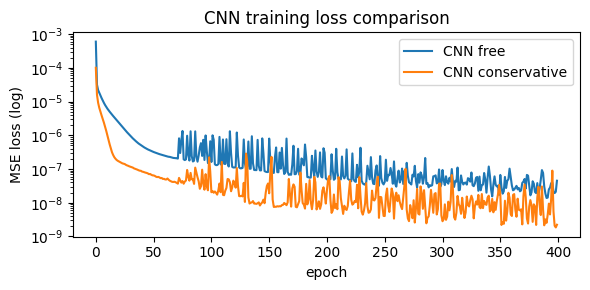

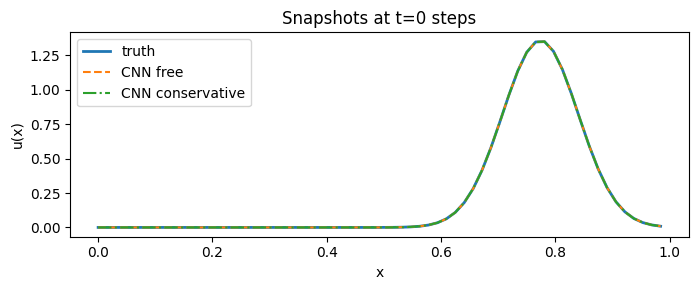

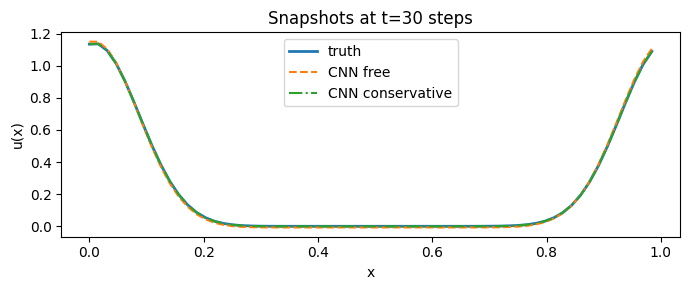

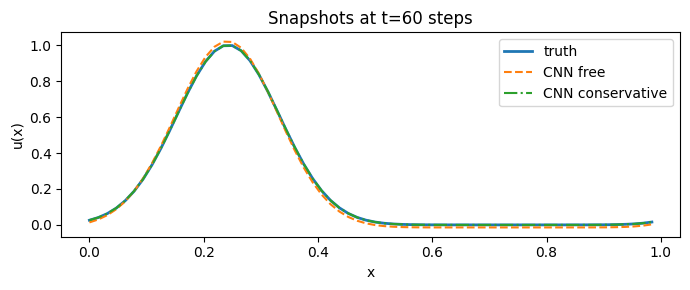

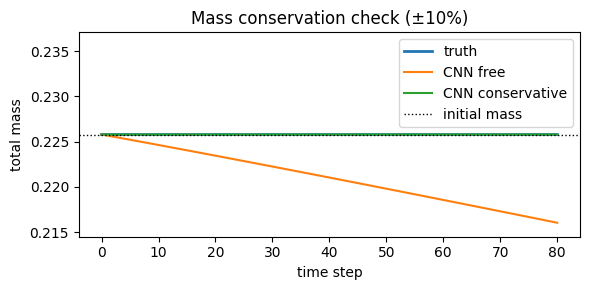

Mass drift (end-start):
 truth: +0.000e+00
 free : -9.744e-03
 cons : -1.490e-08


In [9]:
"""
Cell B — CNN comparison diagnostics

We compare:
- truth
- CNN without mass conservation
- CNN with exact mass conservation

Diagnostics:
1) training loss
2) solution snapshots at t=0,30,60
3) mass conservation with ±10% band
"""

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Rollout utilities (batch-safe)
# ----------------------------
def rollout_model(model, u0_np, n_steps=80):
    u = torch.tensor(u0_np, dtype=torch.float32).unsqueeze(0)
    traj = [u.squeeze(0).numpy().copy()]
    for _ in range(n_steps):
        with torch.no_grad():
            u = model(u)
        traj.append(u.squeeze(0).numpy().copy())
    return np.stack(traj, axis=0)

def mass_series(traj):
    return dx * traj.sum(axis=1)

# Rollouts
traj_free = rollout_model(model_free, u0, n_steps=80)
traj_cons = rollout_model(model_cons, u0, n_steps=80)

# ----------------------------
# Plot 1 — Training loss
# ----------------------------
plt.figure(figsize=(6,3))
plt.plot(loss_hist_free, label="CNN free")
plt.plot(loss_hist_cons, label="CNN conservative")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE loss (log)")
plt.title("CNN training loss comparison")
plt.legend()
plt.tight_layout()
plt.savefig(f"Advection_Periodic_CNN_Loss1.png")
plt.show()

# ----------------------------
# Plot 2 — Snapshots
# ----------------------------
for s in [0, 30, 60]:
    plt.figure(figsize=(7,3))
    plt.plot(x, truth[s], label="truth", linewidth=2)
    plt.plot(x, traj_free[s], label="CNN free", linestyle="--")
    plt.plot(x, traj_cons[s], label="CNN conservative", linestyle="-.")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title(f"Snapshots at t={s} steps")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Advection_Periodic_CNN_{s}.png")
    plt.show()

# ----------------------------
# Plot 3 — Mass conservation (±5% band)
# ----------------------------
m_truth = mass_series(truth)
m_free  = mass_series(traj_free)
m_cons  = mass_series(traj_cons)

M0 = m_truth[0]

plt.figure(figsize=(6,3))
plt.plot(m_truth, label="truth", linewidth=2)
plt.plot(m_free,  label="CNN free")
plt.plot(m_cons,  label="CNN conservative")
plt.axhline(M0, color="k", linestyle=":", linewidth=1, label="initial mass")
plt.ylim(0.95*M0, 1.05*M0)
plt.xlabel("time step")
plt.ylabel("total mass")
plt.title("Mass conservation check (±10%)")
plt.legend()
plt.tight_layout()
plt.savefig(f"Advection_Periodic_CNN_Mass_Conservation_Test1.png")
plt.show()

print("Mass drift (end-start):")
print(f" truth: {m_truth[-1]-m_truth[0]:+.3e}")
print(f" free : {m_free[-1]-m_free[0]:+.3e}")
print(f" cons : {m_cons[-1]-m_cons[0]:+.3e}")

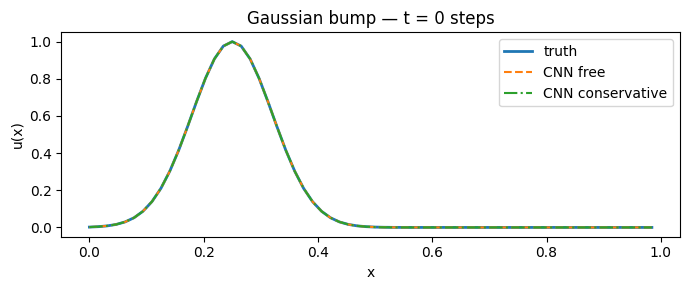

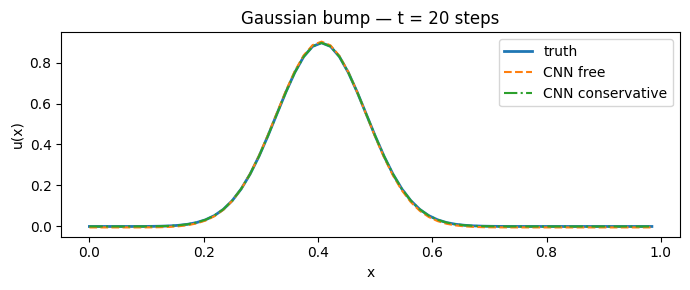

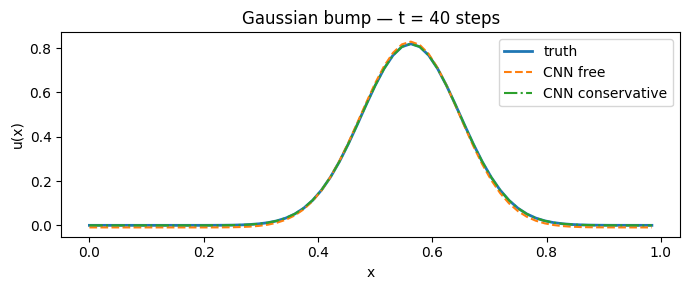

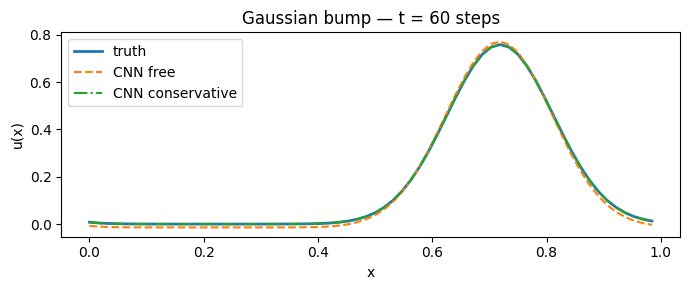

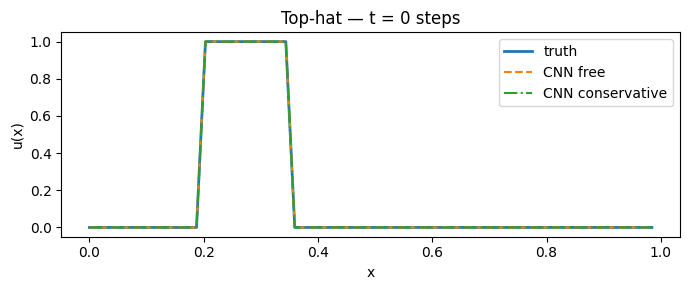

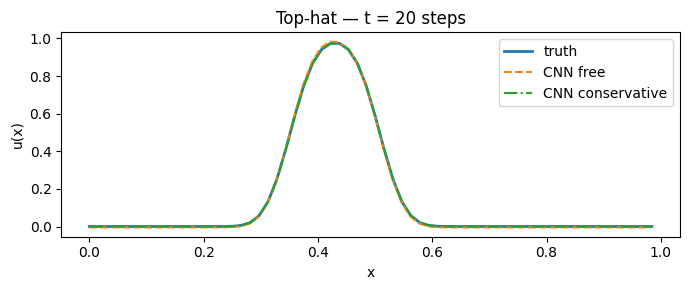

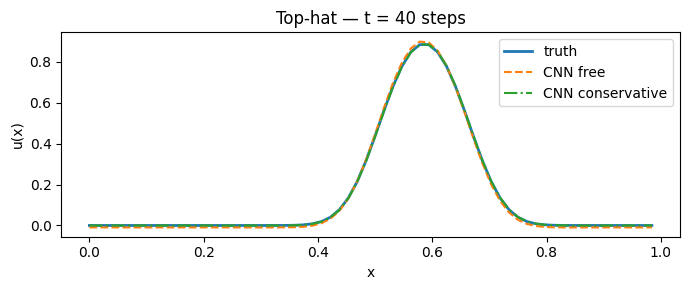

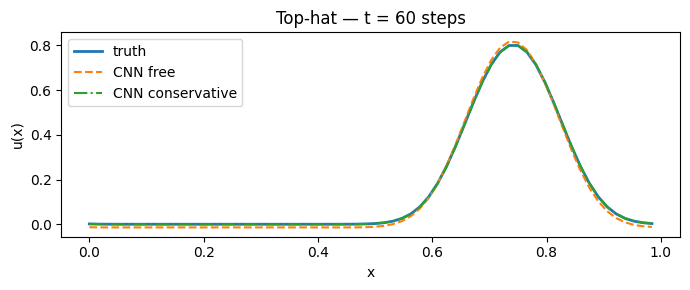

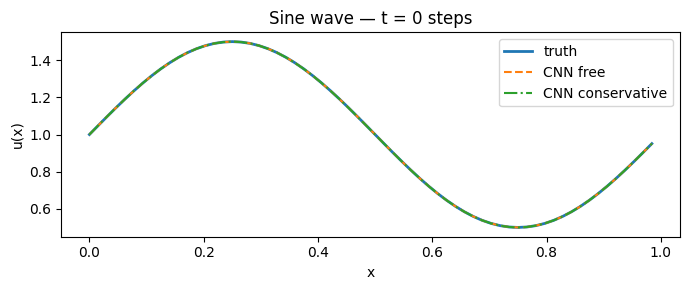

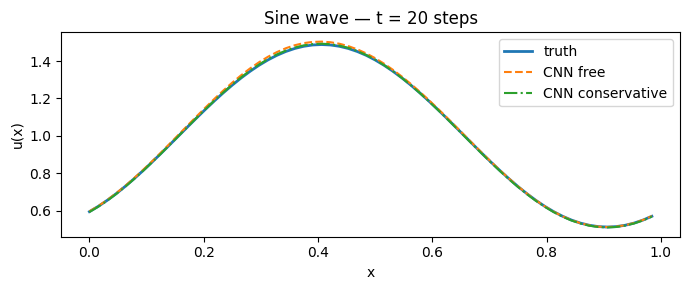

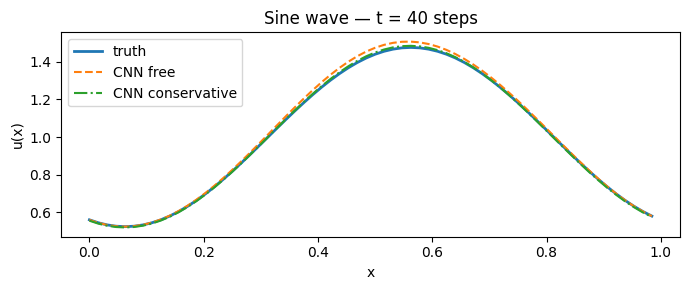

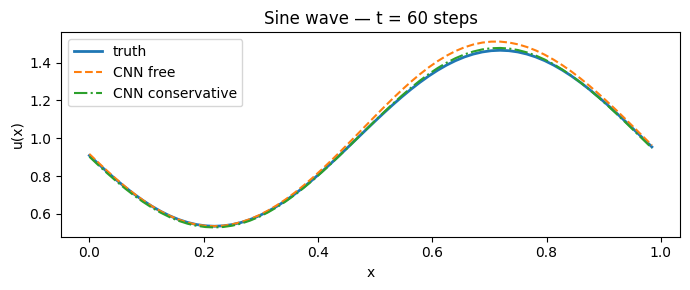

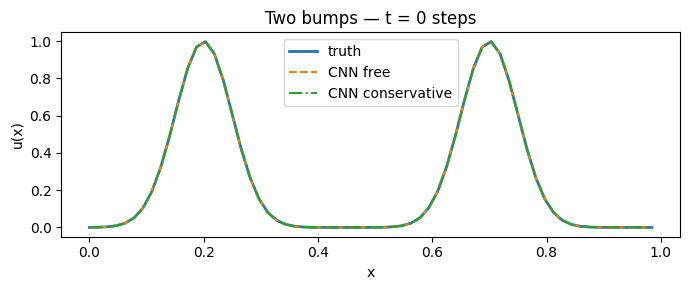

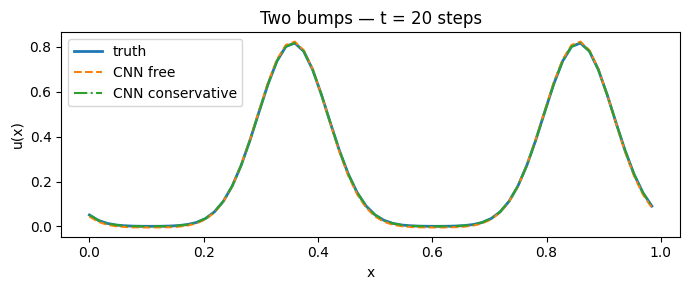

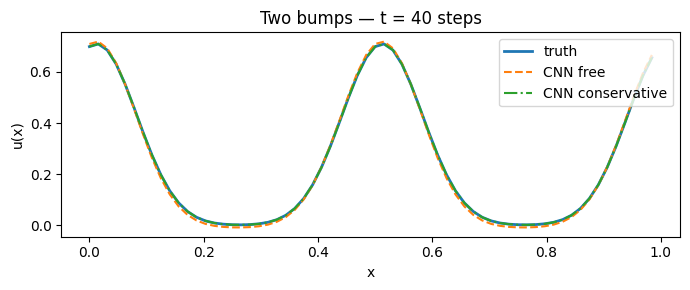

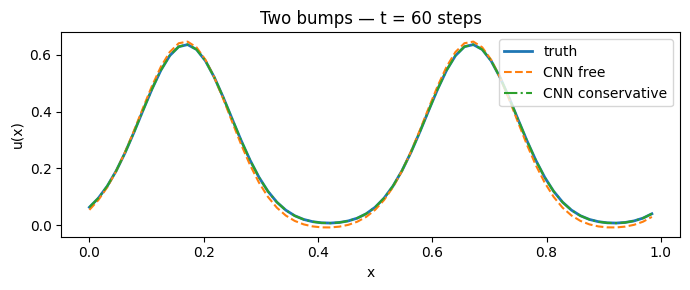

In [10]:
"""
Diagnostics — Generalization to different shapes (truth vs prediction)

We test the trained models on shapes NOT seen during training:
- Gaussian bump (baseline)
- Top-hat (discontinuous)
- Sine wave
- Two separated bumps

For each shape we compare:
- truth (conservative upwind solver)
- CNN free
- CNN conservative

Snapshots are shown at multiple times to visualize advection on the ring.
"""

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Shape definitions
# ----------------------------
def shape_gaussian():
    return np.exp(-((x - 0.25)**2) / 0.01)

def shape_tophat():
    return ((x > 0.2) & (x < 0.35)).astype(float)

def shape_sine():
    return 1.0 + 0.5 * np.sin(2 * np.pi * x)

def shape_two_bumps():
    return (
        np.exp(-((x - 0.2)**2) / 0.005) +
        np.exp(-((x - 0.7)**2) / 0.005)
    )

shapes = {
    "Gaussian bump": shape_gaussian,
    "Top-hat": shape_tophat,
    "Sine wave": shape_sine,
    "Two bumps": shape_two_bumps,
}

# ----------------------------
# Rollout utilities
# ----------------------------
def rollout_truth(u0_np, n_steps=80):
    u = u0_np.copy()
    traj = [u.copy()]
    for _ in range(n_steps):
        u = step_upwind(u)
        traj.append(u.copy())
    return np.stack(traj, axis=0)

def rollout_nn(model, u0_np, n_steps=80):
    u = torch.tensor(u0_np, dtype=torch.float32).unsqueeze(0)
    traj = [u.squeeze(0).numpy().copy()]
    for _ in range(n_steps):
        with torch.no_grad():
            u = model(u)
        traj.append(u.squeeze(0).numpy().copy())
    return np.stack(traj, axis=0)

# ----------------------------
# Diagnostic plots
# ----------------------------
steps_to_show = [0, 20, 40, 60]

nexpl = 0
for name, shape_fn in shapes.items():
    u0_test = shape_fn().astype(np.float32)

    truth_traj = rollout_truth(u0_test, n_steps=80)
    free_traj  = rollout_nn(model_free, u0_test, n_steps=80)
    cons_traj  = rollout_nn(model_cons, u0_test, n_steps=80)

    nexpl = nexpl + 1
    for s in steps_to_show:
        plt.figure(figsize=(7,3))
        plt.plot(x, truth_traj[s], label="truth", linewidth=2)
        plt.plot(x, free_traj[s],  label="CNN free", linestyle="--")
        plt.plot(x, cons_traj[s],  label="CNN conservative", linestyle="-.")
        plt.xlabel("x")
        plt.ylabel("u(x)")
        plt.title(f"{name} — t = {s} steps")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"Advection_Periodic_CNN_{nexpl}_{s}.png")
        plt.show()


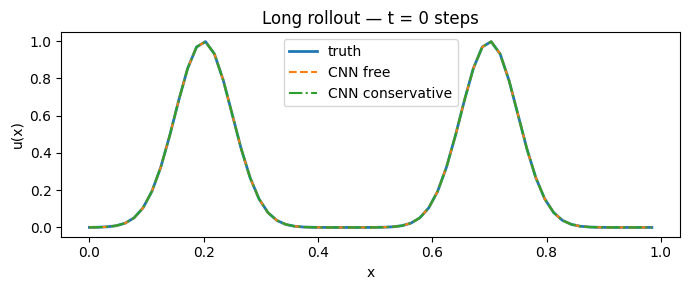

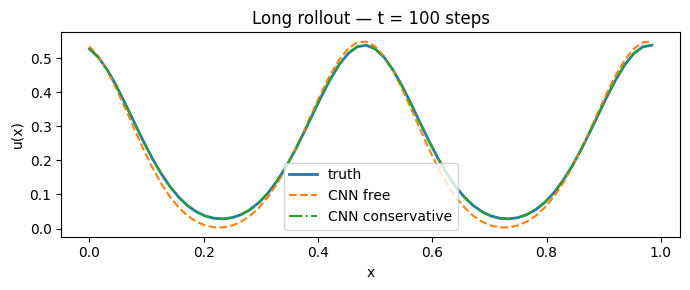

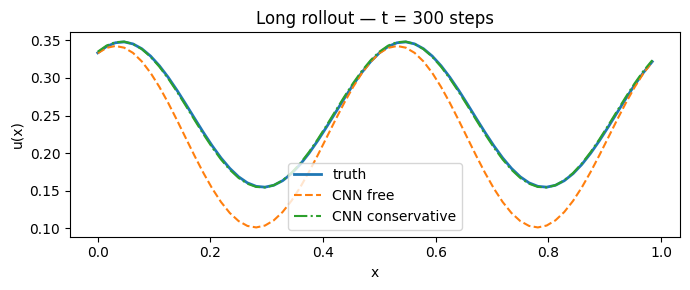

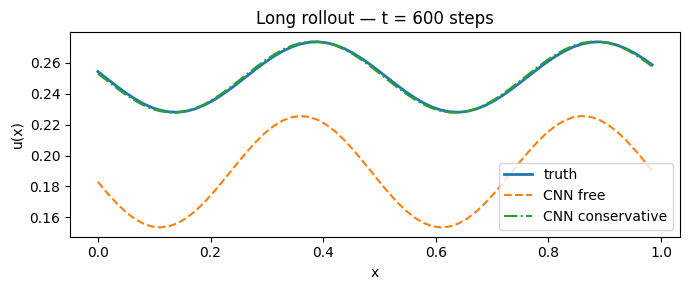

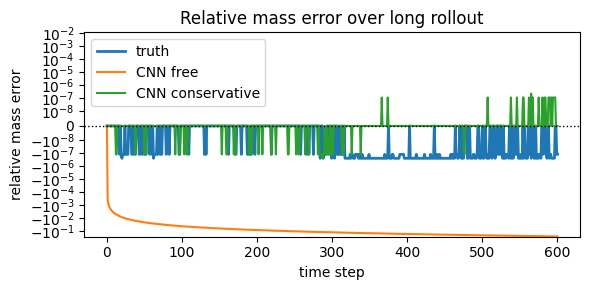

Final relative mass error:
 truth: -1.189e-07
 free : -2.438e-01
 cons : +0.000e+00


In [11]:
"""
Long-time diagnostics — shape evolution and mass error

We run long rollouts (hundreds of steps) and track:
1) Curve behaviour (truth vs CNN free vs CNN conservative)
2) Relative mass error over time

This reveals long-term stability vs short-term accuracy.
"""

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Long rollout parameters
# ----------------------------
n_steps_long = 600
snapshots = [0, 100, 300, 600]

# choose one challenging shape (change freely)
u0_test = shape_two_bumps().astype(np.float32)

# ----------------------------
# Long rollouts
# ----------------------------
truth_long = rollout_truth(u0_test, n_steps=n_steps_long)
free_long  = rollout_nn(model_free, u0_test, n_steps=n_steps_long)
cons_long  = rollout_nn(model_cons, u0_test, n_steps=n_steps_long)

# ----------------------------
# Mass diagnostics
# ----------------------------
def rel_mass_error(traj):
    m = dx * traj.sum(axis=1)
    return (m - m[0]) / m[0]

err_truth = rel_mass_error(truth_long)
err_free  = rel_mass_error(free_long)
err_cons  = rel_mass_error(cons_long)

# ----------------------------
# Plot 1 — Shape evolution at selected long times
# ----------------------------
for s in snapshots:
    plt.figure(figsize=(7,3))
    plt.plot(x, truth_long[s], label="truth", linewidth=2)
    plt.plot(x, free_long[s],  label="CNN free", linestyle="--")
    plt.plot(x, cons_long[s],  label="CNN conservative", linestyle="-.")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title(f"Long rollout — t = {s} steps")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Advection_Periodic_CNN_Long_{s}.png")
    plt.show()

# ----------------------------
# Plot 2 — Relative mass error (log scale)
# ----------------------------
plt.figure(figsize=(6,3))
plt.plot(err_truth, label="truth", linewidth=2)
plt.plot(err_free,  label="CNN free")
plt.plot(err_cons,  label="CNN conservative")
plt.axhline(0.0, color="k", linestyle=":", linewidth=1)

plt.yscale("symlog", linthresh=1e-8)
plt.xlabel("time step")
plt.ylabel("relative mass error")
plt.title("Relative mass error over long rollout")
plt.legend()
plt.tight_layout()
plt.savefig(f"Advection_Periodic_CNN_Long_Mass_Conservation_Test.png")
plt.show()

# ----------------------------
# Print final diagnostics
# ----------------------------
print("Final relative mass error:")
print(f" truth: {err_truth[-1]:+.3e}")
print(f" free : {err_free[-1]:+.3e}")
print(f" cons : {err_cons[-1]:+.3e}")


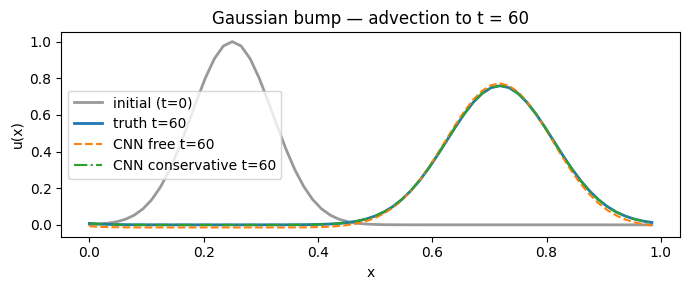

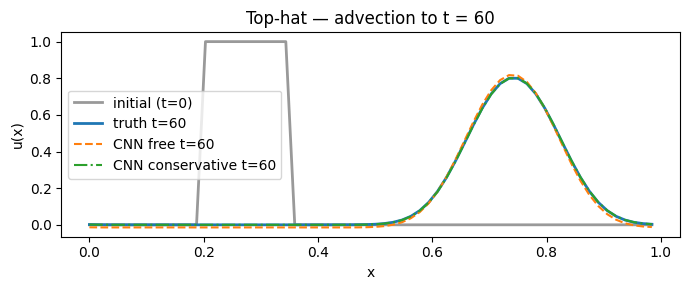

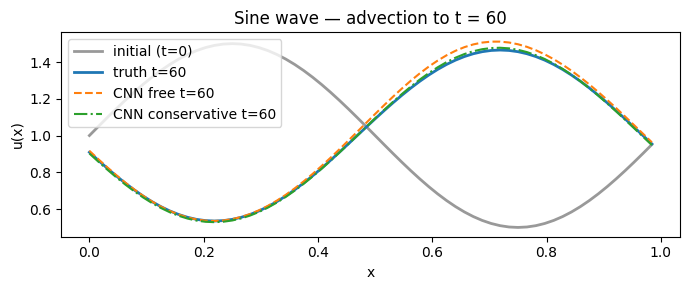

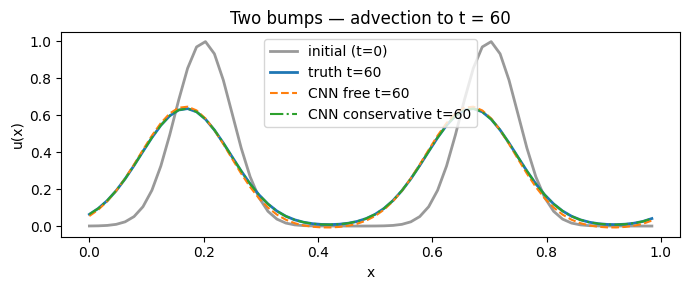

In [12]:
"""
Diagnostics — Generalization to different shapes (compact plots)

For each unseen shape:
- gray: initial condition (t = 0)
- colored: state at t = 60
  - truth
  - CNN free
  - CNN conservative

One figure per shape, saved with consistent filenames.
"""

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Shape definitions
# ----------------------------
def shape_gaussian():
    return np.exp(-((x - 0.25)**2) / 0.01)

def shape_tophat():
    return ((x > 0.2) & (x < 0.35)).astype(float)

def shape_sine():
    return 1.0 + 0.5 * np.sin(2 * np.pi * x)

def shape_two_bumps():
    return (
        np.exp(-((x - 0.2)**2) / 0.005) +
        np.exp(-((x - 0.7)**2) / 0.005)
    )

shapes = {
    "Gaussian bump": shape_gaussian,
    "Top-hat": shape_tophat,
    "Sine wave": shape_sine,
    "Two bumps": shape_two_bumps,
}

# ----------------------------
# Rollout utilities
# ----------------------------
def rollout_truth(u0_np, n_steps=80):
    u = u0_np.copy()
    traj = [u.copy()]
    for _ in range(n_steps):
        u = step_upwind(u)
        traj.append(u.copy())
    return np.stack(traj, axis=0)

def rollout_nn(model, u0_np, n_steps=80):
    u = torch.tensor(u0_np, dtype=torch.float32).unsqueeze(0)
    traj = [u.squeeze(0).numpy().copy()]
    for _ in range(n_steps):
        with torch.no_grad():
            u = model(u)
        traj.append(u.squeeze(0).numpy().copy())
    return np.stack(traj, axis=0)

# ----------------------------
# Compact diagnostic plots
# ----------------------------
t_show = 60
nexpl = 0

for name, shape_fn in shapes.items():
    nexpl += 1
    u0_test = shape_fn().astype(np.float32)

    truth_traj = rollout_truth(u0_test, n_steps=80)
    free_traj  = rollout_nn(model_free, u0_test, n_steps=80)
    cons_traj  = rollout_nn(model_cons, u0_test, n_steps=80)

    plt.figure(figsize=(7,3))

    # initial condition
    plt.plot(
        x, truth_traj[0],
        color="0.6", linewidth=2,
        label="initial (t=0)"
    )

    # t = 60
    plt.plot(x, truth_traj[t_show], label="truth t=60", linewidth=2)
    plt.plot(x, free_traj[t_show],  label="CNN free t=60", linestyle="--")
    plt.plot(x, cons_traj[t_show],  label="CNN conservative t=60", linestyle="-.")

    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title(f"{name} — advection to t = {t_show}")
    plt.legend()
    plt.tight_layout()

    plt.savefig(f"Advection_Periodic_CNN_B_{nexpl}_{t_show}.png")
    plt.show()
